# get all primers
- in the last order
- in previous orders

# get all readout probes
- ...
- ...

# run NUPACK
- simulate reverse one at a time

In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO
import Bio.SeqUtils.MeltingTemp as mt
import os
import nupack

from dredFISH.Utils.__init__plots import *

In [2]:
def parse_encoding_complex(seq, option='+'):
    # P1-R-a-E-a-R-a-R-P2
    breakpoints = np.array([0, 20, 40, 41, 71, 72, 92, 93, 113, 133])
    if option == '+': # 1R-2R
        bp = breakpoints
        
        p1 = seq[bp[0]:bp[1]]
        R1 = seq[bp[1]:bp[2]]
        s1 = seq[bp[2]:bp[3]]
        E  = seq[bp[3]:bp[4]]
        s2 = seq[bp[4]:bp[5]]
        R2 = seq[bp[5]:bp[6]]
        s3 = seq[bp[6]:bp[7]]
        R3 = seq[bp[7]:bp[8]]
        p2 = seq[bp[8]:bp[9]]
        
        return E, R1, R2, R3, p1, p2, s1, s2, s3,  
        
    if option == '-': # 2R-1R
        bp = (133 - breakpoints)[::-1]
    
        p1 = seq[bp[0]:bp[1]]
        R1 = seq[bp[1]:bp[2]]
        s1 = seq[bp[2]:bp[3]]
        R2 = seq[bp[3]:bp[4]]
        s2 = seq[bp[4]:bp[5]]
        E  = seq[bp[5]:bp[6]]
        s3 = seq[bp[6]:bp[7]]
        R3 = seq[bp[7]:bp[8]]
        p2 = seq[bp[8]:bp[9]]
        
        return E, R1, R2, R3, p1, p2, s1, s2, s3,  
    
def parse_encoding(seq):
    """
    """
    # P1-R-a-E-a-R-P2
    breakpoints = np.array([0, 20, 40, 41, 71, 72, 92, 112])
    bp = breakpoints

    p1 = seq[bp[0]:bp[1]]
    R1 = seq[bp[1]:bp[2]]
    s1 = seq[bp[2]:bp[3]]
    E  = seq[bp[3]:bp[4]]
    s2 = seq[bp[4]:bp[5]]
    R2 = seq[bp[5]:bp[6]]
    p2 = seq[bp[6]:bp[7]]

    return E, R1, R2, p1, p2, s1, s2


In [3]:
def recalc_tm(seq, fmd=0, Na=1e-5, dnac1=0, dnac2=0):
    """
    """
    res = mt.Tm_NN(seq, Na=Na, dnac1=dnac1, dnac2=dnac2)
    res = mt.chem_correction(res, fmd=fmd)
    return res
    
def get_gc(seq):
    """
    """
    return (seq.count('G') + seq.count('C'))/len(seq)

In [4]:
def tabulate_results(tube_results, name='t1'):
    conc = pd.Series({key.name.strip("()"): item for key, item in 
            tube_results[name].complex_concentrations.items()
           })
    return conc
    
def summarize(conc, readout_i):
    """
    """
    lbl_signal = f'r{readout_i}+e{readout_i}'
    lbl_signal2 = f'e{readout_i}+r{readout_i}'
    
    lbl_floating = [f'r{readout_i}',
                    f'r{readout_i}+r{readout_i}',
                   ]
    
    ### this was flawed
    total   = pd.concat([
                conc.filter(regex=f'^r{readout_i}\+'),
                conc.filter(regex=f'\+r{readout_i}$'),
                conc.filter(regex=f'^r{readout_i}$'),
                ]).sum()  # all terms with r
    
    total_e = pd.concat([
                conc.filter(regex=f'^e{readout_i}\+'),
                conc.filter(regex=f'\+e{readout_i}$'),
                conc.filter(regex=f'^e{readout_i}$'),
                ]).sum()  # all terms with e
    ### this was flawed 
    
    if lbl_signal in conc.index.values:
        signal = conc.loc[lbl_signal]
    elif lbl_signal2 in conc.index.values:
        signal = conc.loc[lbl_signal2]
        
    floating = conc.loc[lbl_floating].sum()
    
    usage = signal/total # fraction of provided r that goes to signal
    precision = signal/(total-floating) # fraction of correct binding
    recall = signal/total_e
    
    return precision, usage, recall

def summarize_heatmap(conc, readout_i):
    """
    """
    e_map = pd.concat([
                conc.filter(regex=f'^e[0-9]+\+r{readout_i}'),
                conc.filter(regex=f'^r{readout_i}\+e'),
                ])  # all terms with e
    
    
    newidx = np.hstack([[int(j[len('e'):]) for j in lbl.split('+') if j.startswith('e')] for lbl in e_map.index])
    return e_map.iloc[np.argsort(newidx)].values

def summarize_heatmap_fast(conc, readout_i):
    """
    """
    case1 = conc.filter(regex=f'^r{readout_i}\+e')  # r0+e...
    newidx1 = [int(lbl.split('+')[1][1:]) for lbl in case1.index]
    
    case2 = conc.filter(regex=f'^e[0-9]+\+r{readout_i}') # e..+r0
    newidx2 = [int(lbl.split('+')[0][1:]) for lbl in case2.index]
    
    vec = np.zeros(len(case1)+len(case2))
    vec[newidx1] = case1.values
    vec[newidx2] = case2.values
    return vec

In [5]:
def run_n_readouts(seqs_rdt, seqs_enc, seqs_tag, conc_r, conc_e, 
                   ts=[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
                   adaptive=False):
    num_tubes = len(seqs_rdt)
    
    # specify strands
    strands_e = [nupack.Strand(seq_enc, name=f"e{i}") 
                 for i, seq_enc in enumerate(seqs_enc)]
    
    tubes = []
    for tube_idx in np.arange(num_tubes):
        readout_i = tube_idx
        tube_name = f'tube{tube_idx}'
        strand_r = nupack.Strand(seqs_rdt[readout_i], name=f"r{readout_i}")
        if adaptive:
            strands_tube = {strand: conc_e for strand in 
                            strands_e[readout_i:]} # exclude previous
        else:
            strands_tube = {strand: conc_e for strand in 
                            strands_e} # include all
        strands_tube[strand_r] = conc_r
        tube = nupack.Tube(strands=strands_tube,  
                         complexes=nupack.SetSpec(max_size=2), 
                         name=tube_name)
        tubes.append(tube)
    
    # analyze with different model temperatures
    res = [] 
    emaps = {}
    for t in ts:
        print('>', end='')
        emaps[t] = []
        model = nupack.Model(material='dna', 
                              celsius=t,
                              sodium=0.3,
                             )
        tube_results = nupack.tube_analysis(tubes=tubes, model=model)
        
        for tube_idx in np.arange(num_tubes):
            print('.', end='')
            readout_i = tube_idx
            tube_name = f'tube{tube_idx}'
            conc = tabulate_results(tube_results, name=tube_name)
            precision, usage, recall = summarize(conc, readout_i)
            emap = summarize_heatmap_fast(conc, readout_i)
            emaps[t].append(emap)
            res.append({'t': t,
                        'index': tube_idx,
                        'tube': tube_name,
                        'hybe': seqs_tag[readout_i],
                        'precision': precision,
                        'usage': usage,
                        'recall': recall,
                       })
        print("")

    res = pd.DataFrame(res)
    return res, emaps

In [6]:
def plot_tube(resplot, ax_row):
    ax = ax_row[0]
    ax.plot(resplot['t'], resplot['usage'], '-o')
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Usage')
    sns.despine(ax=ax)

    ax = ax_row[1]
    ax.plot(resplot['t'], resplot['precision'], '-o')
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Precision')
    sns.despine(ax=ax)

    ax = ax_row[2]
    ax.plot(resplot['t'], resplot['recall'], '-o')
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Recall')
    sns.despine(ax=ax)

def plot_tube_simple(resplot, ax_row, **kwargs):
    ax = ax_row[0]
    ax.plot(resplot['t'], resplot['precision'], '-o', **kwargs)
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Precision')
    sns.despine(ax=ax)

    ax = ax_row[1]
    ax.plot(resplot['t'], resplot['recall'], '-o', **kwargs)
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Recall')
    sns.despine(ax=ax)
    
def plot_tube_simple_v2(resplot, ax_row, **kwargs):
    p, r = resplot['precision'], resplot['recall']
    minpr = np.minimum(p, r)
    f1 = 2/(1/p+1/r)
    
    ax = ax_row[0]
    ax.plot(resplot['t'], p, '-o', **kwargs)
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Precision')
    sns.despine(ax=ax)
    
    ax = ax_row[1]
    ax.plot(resplot['t'], r, '-o', **kwargs)
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Recall')
    sns.despine(ax=ax)
    
    ax = ax_row[2]
    ax.plot(resplot['t'], minpr, '-o', **kwargs)
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Min (Prec., Recall)')
    sns.despine(ax=ax)


def plot_tube_f1(resplot, ax_row, **kwargs):
    p, r = resplot['precision'], resplot['recall']
    minpr = np.minimum(p, r)
    f1 = 2/(1/p+1/r)
    
    ax = ax_row[0]
    ax.plot(resplot['t'], minpr, '-o', **kwargs)
    ax.set_xlabel('Celsius')
    ax.set_ylabel('Min (Prec., Recall)')
    sns.despine(ax=ax)

    ax = ax_row[1]
    ax.plot(resplot['t'], f1, '-o', **kwargs)
    ax.set_xlabel('Celsius')
    ax.set_ylabel('F1 score (HM)')
    sns.despine(ax=ax)

In [7]:
f = '/greendata/GeneralStorage/fangming/projects/dredfish/res_seq/dredFISH_PNMF_DPNMF_IEG_pFinal_Oligos_Nov2022_v6.fasta'

In [8]:
# f = "/bigstore/binfo/Probe_Sets/dredFISH_Final_Oligos.fasta"

In [9]:
resall = []
# encseqs = []
rdtseqs = []
rdtnames = []
p1seqs = []
p2seqs = []

for i, record in enumerate(SeqIO.parse(f, "fasta")):
    seq = record.seq
    dsp = record.description
    
    E, R1,R2, p1,p2, s1,s2, = parse_encoding(seq)
    if (str(s1),str(s2)) == ('A', 'A'):
        pass
    else:
        print(s1,s2)
        break
        
    assert R1 == R2
    
    rdtseqs.append(str(R1))
    rdtnames.append(dsp.split(' ')[3])
    
    p1seqs.append(str(p1))
    p2seqs.append(str(p2))
    
    # if i > 100:
    #     break

In [10]:
p1seqs = np.unique(p1seqs)
p2seqs = np.unique(p2seqs)
p1seqs, p2seqs

(array(['ACGATCTGCTGCGCGTACCT', 'CATGGCATTCTTCGCCGGCT',
        'CCTGCACAAATCGTTGCGGT', 'CGCTTTCGAATACGCCGAGT',
        'GCGTGTAGGCACGCAAGAGT', 'TCCTCCGACCGAAGCTGGAT',
        'TGTTCCGCACGCCGTCTCTT'], dtype='<U20'),
 array(['CGTTAACCTGGCCCGGCTAC', 'CGTTAACTGTGACCGCCCGT',
        'GCGTACGAGACCCGGTACTG', 'GGTTAACAGGCGTCGGCTGA',
        'GGTTAACTCGCGACACGTGG', 'TGCTAGCCAACTAACGCGCC',
        'TGTTAACGGAAACGCGACGG'], dtype='<U20'))

In [11]:
# specify strands
a = nupack.Strand('CTGATCGATC', name='a')
b = nupack.Strand('GATCGTAGTC', name='b')
strands = {}
for i, seq in enumerate(p1seqs):
    seq, seqname, seqconc = seq, f'p1_{i}', 1e-9
    strands[nupack.Strand(seq, name=seqname)] = seqconc
for i, seq in enumerate(p2seqs):
    seq, seqname, seqconc = seq, f'p2_{i}', 1e-9
    strands[nupack.Strand(seq, name=seqname)] = seqconc

# specify tubes
t1 = nupack.Tube(strands=strands, complexes=nupack.SetSpec(max_size=2), name='t1')

# analyze tubes
model1 = nupack.Model(material='dna', 
                      celsius=37,
                      sodium=1,
                     )
tube_results = nupack.tube_analysis(tubes=[t1], model=model1)
res = tabulate_results(tube_results, name='t1')
res = res.sort_values(ascending=False)
res

p1_4         9.999946e-10
p1_5         9.999789e-10
p1_3         9.999535e-10
p2_2         9.999400e-10
p1_2         9.999207e-10
                 ...     
p2_2+p2_3    6.976089e-17
p1_2+p2_3    5.429862e-17
p1_4+p2_6    3.924605e-17
p1_4+p2_3    1.184087e-17
p1_4+p1_4    3.661580e-18
Length: 119, dtype: float64

In [19]:
type(tube_results)

nupack.named.Result

In [12]:
from scipy.special import comb

In [13]:
def get_num_combinations(n):
    """
    """
    return n+n+comb(n,2)
    

In [14]:
def assign_group(index):
    """
    """
    if "+" not in index:
        label = "single"
    else:
        a, b = index.split('+')
        if a == b:
            label = "self-bind"
        else:
            label = "cross-bind"
            
    return label
        

In [15]:
get_num_combinations(14)

119.0

In [16]:
baseconc = 1e-9

In [17]:
resfancy = res.sort_values(ascending=False).to_frame("conc")
resfancy['order'] = np.arange(len(resfancy))
resfancy["log10frac"] = np.log10(resfancy['conc']/baseconc)
resfancy["group"] = [assign_group(idx) for idx in resfancy.index.values]
resfancy

,conc,order,log10frac,group
p1_4,9.999946e-10,0,-0.000002,single
p1_5,9.999789e-10,1,-0.000009,single
p1_3,9.999535e-10,2,-0.000020,single
p2_2,9.999400e-10,3,-0.000026,single
p1_2,9.999207e-10,4,-0.000034,single
...,...,...,...,...
p2_2+p2_3,6.976089e-17,114,-7.156388,cross-bind
p1_2+p2_3,5.429862e-17,115,-7.265211,cross-bind
p1_4+p2_6,3.924605e-17,116,-7.406204,cross-bind
p1_4+p2_3,1.184087e-17,117,-7.926616,cross-bind


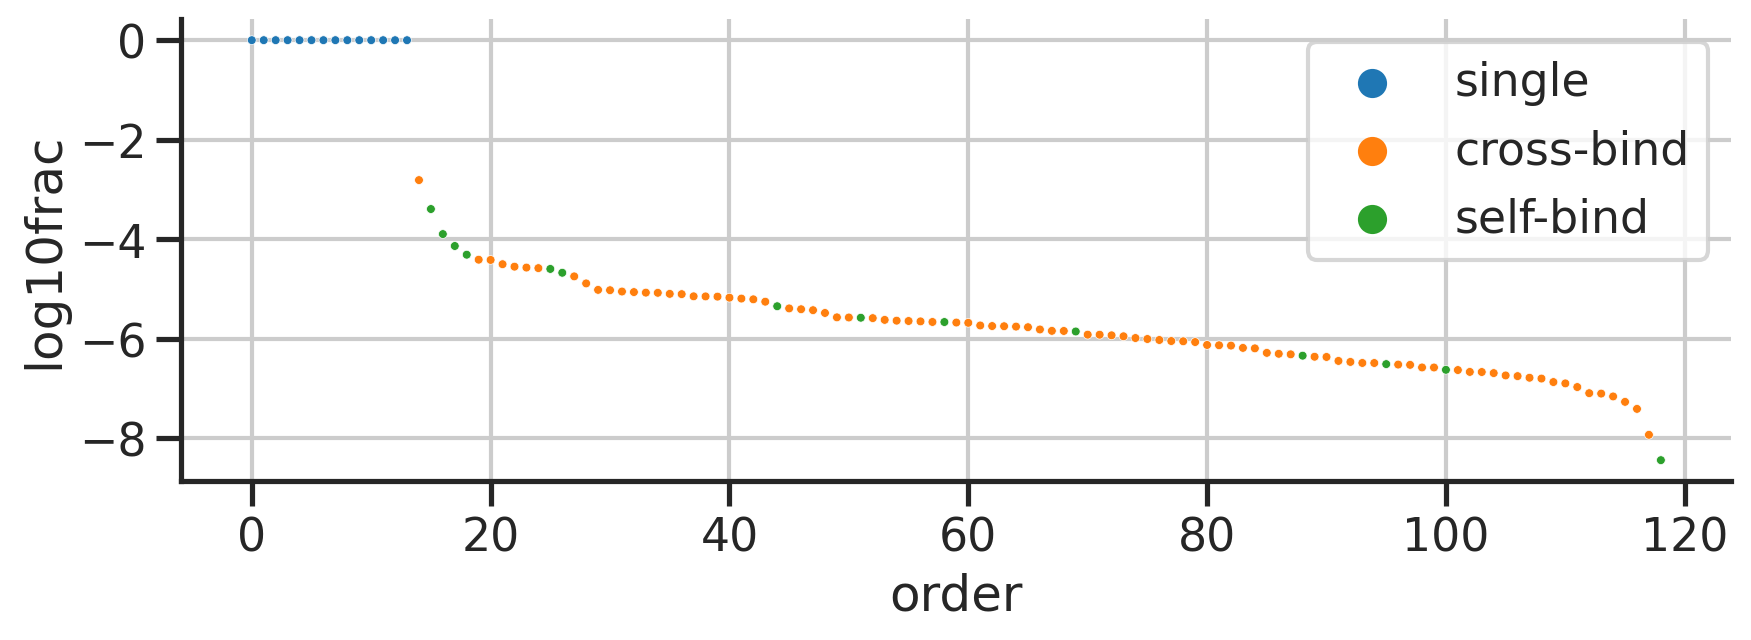

In [18]:
fig, ax = plt.subplots(figsize=(10,3))
sns.scatterplot(data=resfancy, x='order', y='log10frac', hue='group', s=10)
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
plt.show()